In [ ]:
# GDAL commands used to select the portions of data sources that we need

# Select shapefiles from the OSM data
!ogr2ogr -sql "SELECT * FROM multipolygons WHERE admin_level='8'" -f "ESRI Shapefile" bay_area_cities bay_area.osm.pbf
# Select populations from the OSM data
!ogr2ogr -sql "SELECT * FROM points WHERE population IS NOT NULL and name IS NOT NULL" -f "GeoJSON" bay_area_cities.geojson bay_area.osm.pbf 
# Merge a set of downloaded SRTM elevation data
!gdal_merge.py -o bay_area.tif -of GTiff bay_area_data/N3?W12?.hgt

In [1]:
import json

import numpy as np
import numpy.ma as ma

import gdal

import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib.colors import LightSource, LinearSegmentedColormap

import cartopy.crs as ccrs
from cartopy.io import shapereader

from graph_coloring import generate_intersections, greedy_coloring

In [2]:
# Read the city shapefiles and generate the neighbors map
reader = shapereader.Reader('bay_area_cities/multipolygons.shp')
intersections = generate_intersections(reader, verbose=False)

American Canyon intersects Napa
American Canyon intersects Vallejo
Napa intersects American Canyon
Fremont intersects Milpitas
Fremont intersects b'San Jos\xe9'
Fremont intersects Sunnyvale
Fremont intersects Redwood City
Fremont intersects Hayward
Fremont intersects Palo Alto
Fremont intersects Mountain View
Fremont intersects Menlo Park
Fremont intersects Union City
Fremont intersects Newark
San Francisco intersects Daly City
San Francisco intersects Richmond
San Francisco intersects Tiburon
San Francisco intersects Berkeley
San Francisco intersects Oakland
San Francisco intersects Brisbane
San Francisco intersects Alameda
San Francisco intersects Albany
Los Gatos intersects b'San Jos\xe9'
Los Gatos intersects Saratoga
Los Gatos intersects Campbell
Los Gatos intersects Monte Sereno
Milpitas intersects Fremont
Milpitas intersects b'San Jos\xe9'
b'San Jos\xe9' intersects Fremont
b'San Jos\xe9' intersects Los Gatos
b'San Jos\xe9' intersects Milpitas
b'San Jos\xe9' intersects Sunnyvale
b

In [3]:
# From the neighbors map, assign colors to the cities
colors =['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33']
colormap = greedy_coloring(intersections, colors)

In [9]:
# Open the SRTM elevation file and compute a hillslope
# shaded relief dataset.
data = gdal.Open('bay_area.tif')
arr = data.ReadAsArray()
ls = LightSource()
intensity = ls.hillshade(arr, vert_exag=0.5)

# Construct a mask for water
water = ma.masked_where(arr != 0, np.ones_like(arr))

In [4]:
# Load the population dataset, and construct
# a dictionary containing the population of
# each city.
f = open('bay_area_cities.geojson')
city_data = json.load(f)
population = dict()
for record in city_data['features']:
    name = record['properties']['name']
    # Some populations contain commas, so strip those
    pop = int(record['properties']['population'].replace(',',''))
    if name in population:
        continue
    population[name] = pop

In [24]:
# The label for cities is plotted at the centroid of the shape,
# which is not always the best choice.
# This is a dictionary of manually chosen lon/lat shifts for the
# labels to make the map look good.
tweaks = {
    "San Francisco": [0.25, 0.0],
    "Oakland": [0.0, 0.04]
}

KeyError: 'San José'

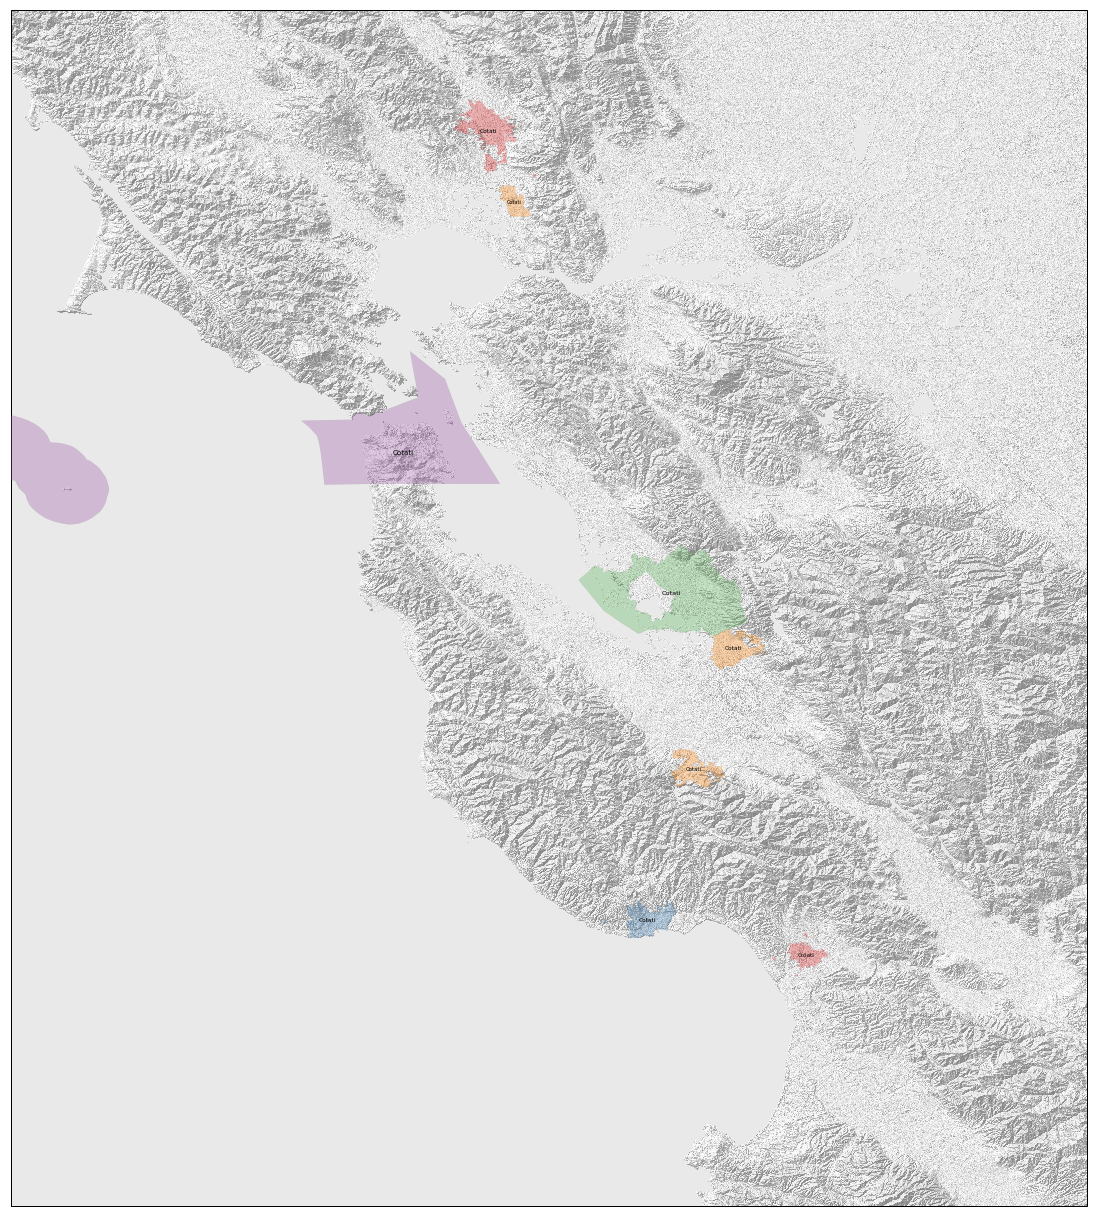

In [25]:
# Construct the map!

fig = plt.figure(figsize=(22, 22))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-123.1,-121.3, 36.5, 38.5]) # Full SF metro area

srtm_extent=[-124.0001389, -120.9998611, 35.9998611, 39.0001389]
ax.imshow(intensity, cmap='gist_gray', alpha=0.5, origin='upper', extent=srtm_extent, zorder=0)

# Duplicated cities that we should skip.
skip = ['City of Cupertino Service Center']
replace = { b'San Jos\xe9': 'San José' }
cities = set()
for record in reader.records():
    name = record.attributes['name']
    geometry = record.geometry
    if name == '' or name in cities or name in skip:
        continue
    cities.add(name)
    ax.add_geometries([geometry], ccrs.PlateCarree(), 
                      alpha=0.3, color=colormap[name], 
                      edgecolor='k', lw=0.1, zorder=5)
    # If the population is in the population map (as it is for most cities),
    # assign the font size to the log of the population
    if population.get(name):
        size = np.log10(population[name])*1.2 if population[name] > 0 else 1
    else: 
        size = np.log10(10000)
    label = name if name not in replace else replace[name]
    # Compute the x and y position of the labels, considering the tweaks dictionary
    x = geometry.centroid.x
    y = geometry.centroid.y
    if tweaks.get(name):
        x += tweaks[name][0]
        y += tweaks[name][1]
    ax.text(x, y, label, fontsize=size, zorder=20, clip_on=True,
            ha='center', va='center', transform=ccrs.PlateCarree())

#Make a pure blue colormap, and plot the water mask
cm = LinearSegmentedColormap.from_list('water', [(169/255, 204/255, 227/255),(169/255, 204/255, 227/255)])
ax.imshow(water, cmap=cm, origin='upper', alpha=1.0, extent=srtm_extent, zorder=10)

# Save at a high resolution
plt.savefig('bay_area_cities.pdf', dpi=600)
plt.show()